In [1]:
import numpy as np
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
import pandas
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import statsmodels.stats.multitest as smm


c:\Users\saika\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\saika\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
import sys 
sys.path.append("C://Users//saika//Downloads//Assembly_paper")

In [2]:
from lsmm_data import LSMMData
import json

with open('v1dd_data_structures_information.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
tables = my_data.data
params = my_data.params
dirs = my_data.dirs
mappings = my_data.mappings
 
print(tables['structural']['pre_cell'])
print(tables['structural']['post_cell'])
print(tables['structural']['synapse'])
 
pt_root_id = tables['structural']['pre_cell'].iloc[1]['pt_root_id']
#print("Connectome Index.  Should be 41:", mappings['pt_root_id_to_connectome_index'][pt_root_id])

Generating Connectome...


100%|██████████| 137706/137706 [02:55<00:00, 783.63it/s]


Generating Connectome...


100%|██████████| 137706/137706 [03:21<00:00, 682.37it/s]


     index      id          pt_root_id  pt_position_x  pt_position_y  \
0        9  293764  864691132625300120         878665         697702   
1       41  295576  864691132710501931         842193         737122   
2       62  278405  864691132830575876         737898         601710   
3       76  293733  864691132616354625         858877         700030   
4       85  307952  864691132999200949         867646         840563   
..     ...     ...                 ...            ...            ...   
847   8764  371302  864691132849454803         958050         629957   
848   8769  385115  864691132679146333         975354         850418   
849   8773  383491  864691132763271347         928872         797418   
850   8790  351167  864691132579592205         927863         548865   
851   8794  277788  864691132653866455         853833         547235   

     pt_position_z classification_system cell_type status_axon  \
0           245475            excitatory        4P    extended   
1  

In [3]:
'''---------------------When using LSMM-------------------------------------'''
cell_table = tables['structural']['pre_cell']

weight_matrix = tables['structural']['summed_size_connectome']

In [4]:
x_pos = np.mean(cell_table['pt_position_x_trafo'])   # Centroid of the graph - cartesian co-ordinates system hence, centroid = mean
y_pos = np.mean(cell_table['pt_position_y_trafo'])
z_pos = np.mean(cell_table['pt_position_z_trafo'])
cent_dist_no_a = []
cent_dist_a = []

x_pos, y_pos, z_pos

(-34745.30939045572, 361853.0747079696, -19676.265935433912)

In [11]:
import math 
for cell in mappings['assemblies_by_connectome_index']:
    if mappings['assemblies_by_connectome_index'][cell] == ['No A']:
        cent_dist_no_a.append( np.linalg.norm([cell_table['pt_position_x_trafo'][cell] -  x_pos, cell_table['pt_position_y_trafo'][cell] - y_pos], axis = 0))
    else:
        cent_dist_a.append(np.linalg.norm([cell_table['pt_position_x_trafo'][cell] - x_pos, cell_table['pt_position_y_trafo'][cell] -  y_pos], axis = 0))

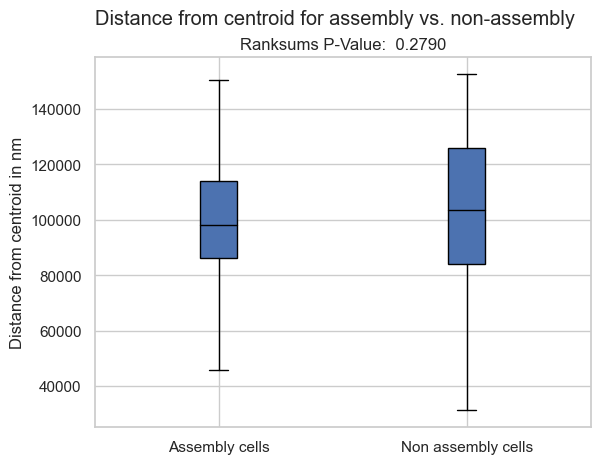

distance from centroid : 0.27898411139327395


In [31]:
import scipy
import ptitprince as pt
import random
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
from scipy import stats
import seaborn as sns


light_blue = sns.color_palette("deep")[0]

# Boxplot
fig, ax = plt.subplots()
bp = ax.boxplot([cent_dist_a, cent_dist_no_a], patch_artist=True)

# Apply color
for box in bp['boxes']:
    box.set(facecolor=light_blue)

# Set median color to black
for median in bp['medians']:
    median.set(color='black', linewidth=1)

[stat, p_val]= scipy.stats.ranksums(cent_dist_a, cent_dist_no_a)

plt.xticks([1, 2], ['Assembly cells', 'Non assembly cells'])
plt.ylabel(r"Distance from centroid in nm")
plt.suptitle("Distance from centroid for assembly vs. non-assembly")
plt.title(f"Ranksums P-Value: {p_val: 0.4f}")
plt.show()


print("distance from centroid :", p_val)